In [ ]:
import torch #PyTorch for deep learning
import torchvision.transforms as transforms #image transformations
from torchvision.datasets import ImageFolder #Loading images from folders as datasets.
from torch.utils.data import DataLoader #batch processing of datasets.
from transformers import SwinForImageClassification
import torch.nn as nn #Neural network modules
import torch.optim as optim #Optimization algorithms
import os
import timm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns #data visualization
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report #computing classification metrics.
from google.colab import drive  # For Google Drive access
import shutil
import random
import hashlib

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mount Google Drive to access the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/kidney_ct_scan_dataset"
output_dir = "/content/drive/MyDrive/split_dataset_kidney_ct" #split dataset will be saved here

In [ ]:
# split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for split in ["train", "val", "test"]:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    random.shuffle(images) #to train the model appropriately

    train_split = int(len(images) * train_ratio)
    val_split = int(len(images) * (train_ratio + val_ratio))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "train", class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "val", class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, "test", class_name, img))

In [ ]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 (Swin Transformer input size)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize pixel values (-1 to 1)
])

# Load the Dataset
train_dataset = ImageFolder(os.path.join(output_dir, "train"), transform=transform)
val_dataset = ImageFolder(os.path.join(output_dir, "val"), transform=transform)
test_dataset = ImageFolder(os.path.join(output_dir, "test"), transform=transform)

# Create Data Loaders (For Batch Processing)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle->randomizing the dataset for better results
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load Pretrained Swin Transformer
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
num_classes = len(train_dataset.classes)  # Finds the no. of classes from dataset

# Final Classification Layer Modification
model.classifier = nn.Linear(model.classifier.in_features, num_classes) #replace the final classification layer with a new nn.Linear layer that matches the dataset’s classes.
model.to(device)  # Move model to GPU if available

# Loss Function & Optimizer Definition
criterion = nn.CrossEntropyLoss() # Measures how well the model is classifying images.
optimizer = optim.Adam(model.parameters(), lr=0.0001) # model weights adjustment using a learning rate of 0.0001

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
model.eval() #model set to evaluation mode

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from the untrained model
        outputs = model(images).logits

        # Get the predicted class with highest probability
        _, predicted = torch.max(outputs, 1)

        # Count of predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

pre_training_accuracy = 100 * correct / total
print(f"Pre-training Test Accuracy: {pre_training_accuracy:.2f}%")

Pre-training Test Accuracy: 22.48%


In [ ]:
# Training
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # To get model predictions
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1/7, Loss: 0.1597, Accuracy: 94.32%
Epoch 2/7, Loss: 0.0187, Accuracy: 99.55%
Epoch 3/7, Loss: 0.0168, Accuracy: 99.40%
Epoch 4/7, Loss: 0.0085, Accuracy: 99.74%
Epoch 5/7, Loss: 0.0136, Accuracy: 99.60%
Epoch 6/7, Loss: 0.0104, Accuracy: 99.68%
Epoch 7/7, Loss: 0.0191, Accuracy: 99.43%


In [ ]:
# Validation
model.eval()
val_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Validation Loss: 0.0065, Accuracy: 99.84%


In [ ]:
# Testing
model.eval()
test_loss, correct, total = 0.0, 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Test Loss: 0.0112, Accuracy: 99.68%


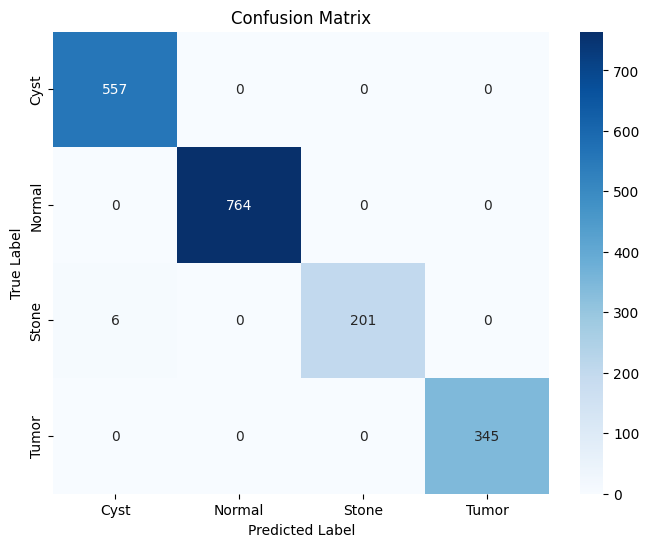

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.99      1.00      0.99       557
      Normal       1.00      1.00      1.00       764
       Stone       1.00      0.97      0.99       207
       Tumor       1.00      1.00      1.00       345

    accuracy                           1.00      1873
   macro avg       1.00      0.99      0.99      1873
weighted avg       1.00      1.00      1.00      1873



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

In [ ]:
# Save the Trained Model
model_save_path = "/content/swin_kidney_ct_scan_detection.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/swin_kidney_ct_scan_detection.pth
